# Load dataset

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 60)
traffic = pd.read_csv("traffic_fines_1.csv", sep=';', low_memory=False)
display(traffic.head(3))
traffic.shape

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,expense,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,0.0,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,11.0,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,11.0,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant


(460556, 21)

In [2]:
import EventLog as el

In [3]:
log = el.EventLog(traffic, 'Case ID', 'Complete Timestamp')

Found False


/Users/florianlang/ProgrammingProjects/python/predictive-monitoring-evolution/EventLog.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  temp = pd.to_datetime(self.df[self.timestamp_column], infer_datetime_format=True,utc=True, errors='raise')


In [4]:
log.static_columns()

['article', 'vehicleClass', 'points', 'timesincemidnight', 'hour', 'label']

In [5]:
log.df.nunique()

article                   50
vehicleClass               4
amount                   204
points                     9
Case ID               129615
Activity                  10
Resource                 148
lastSent                   4
notificationType           3
dismissal                  8
expense                   84
Complete Timestamp      4903
timesincemidnight          1
month                     12
weekday                    7
hour                       1
timesincelastevent      1086
timesincecasestart      1360
event_nr                  20
open_cases             17274
label                      2
dtype: int64

# Preprocess and encode

In [6]:
from sklearn.preprocessing import OneHotEncoder
encoder = el.LogEncoder(transformers = [('static_drop', 'drop', []),
                                     ('static_keep', 'keep', ['amount', 'points']),
                                     ('static_onehot', el.WrapperEncoder(log.id_column,OneHotEncoder(sparse_output=False)), ['article', 'vehicleClass']),
                                     ('dynamic_drop', 'drop', []),
                                     ('dynamic_keep', 'keep', ['expense', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases']),
                                     ('dynamic_freq', el.FrequencyEncoder(log.id_column), ['Activity', 'Resource', 'lastSent','notificationType', 'dismissal']),
                                     ('timestamp', el.TimestampFeatures(log.id_column, ['event_order', 'time_from_start', 'remaining_time', 'elapsed_time_from_event']), [log.timestamp_column])])


encoder.check_unused(log)

['Case ID', 'label']

In [7]:
X = encoder.fit_transform(log)

Fitting static_drop
Fitting static_keep
Fitting static_onehot
Fitting dynamic_drop
Fitting dynamic_keep
Fitting dynamic_freq
Fitting timestamp
Transforming static_drop
Transforming static_keep
Transforming static_onehot
Transforming dynamic_drop
Transforming dynamic_keep
Transforming dynamic_freq
Transforming timestamp


In [8]:
X.shape

(460556, 242)

In [9]:
(X.isnull().sum() > 0).sum()

0

# Descriptive analysis
We show some information concerning the distribution of the label (equally distributed), the categorical values and the events in each year (the number of events decreases with time and 2013 seems incomplete)

In [10]:
y = log.df['label']
y.value_counts()

label
deviant    239478
regular    221078
Name: count, dtype: int64

In [11]:
catcols = list(set(X.columns.values) - set(['amount', 'event_nr', 'expense', 'hour', 'month', 'open_cases', 'timesincecasestart', 'timesincelastevent', 'timesincemidnight', 'weekday']))

In [12]:
X.loc[:,catcols].max()

Resource_557.0     9.0
Resource_43.0     10.0
vehicleClass_A     1.0
Resource_567.0     9.0
Resource_55.0      9.0
                  ... 
Resource_833.0     6.0
article_156.0      1.0
Resource_15.0      9.0
Resource_3.0       4.0
Resource_861.0     7.0
Length: 232, dtype: float64

In [13]:
log.df[log.timestamp_column].dt.year.value_counts()

Complete Timestamp
2000    49467
2006    46157
2005    43633
2001    41835
2009    37676
2002    36165
2007    35385
2008    34177
2011    31678
2004    30191
2003    29034
2010    27840
2012    14715
2013     2603
Name: count, dtype: int64

# Experiments

## RQ1: Does the dataset changes over time?
To answer this question, we split the dataset into a set of intervals (e.g. each 9 months) and test whether the distribution of values of categorical attributes between the different intervals is statistically significant using chi2

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_heatmap(data, vmax=None):
    s = len(data.columns)+1
    yticklabels=['[I'+str(i)+"] "+data.columns[i-1].left.strftime('%m-%Y') + " to " + data.columns[i-1].right.strftime('%m-%Y') for i in range(1,s)]
    xticklabels=['[I'+str(i)+']' for i in range(1,s)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, yticklabels = yticklabels, xticklabels=xticklabels,vmax=vmax)
    ax.set_xlabel("")
    ax.set_ylabel("")    
    
    return ax

In [15]:
from splitters import TimeCaseSplit
from contingency import compute_all_chi2

tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
allchi2 = compute_all_chi2(X.loc[:,catcols], tcs.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]))

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_23607/3220553523.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))


<Axes: >

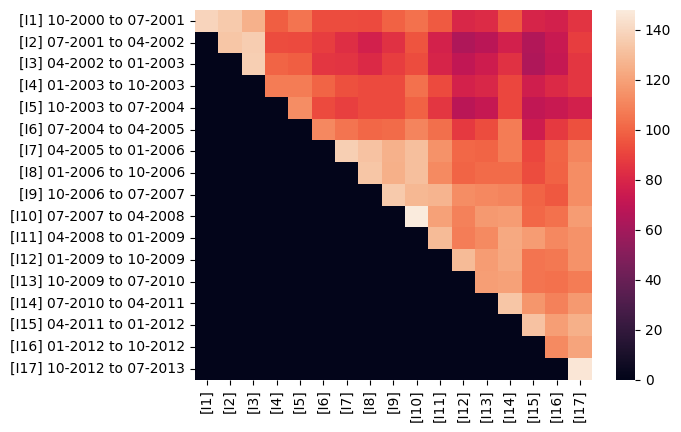

In [16]:
draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))

The conclusion is that there is a difference between the first years of the dataset (until 2003) and the last years (before 2003). Furthermore, as expected, there are more similarities in the diagonal, which represent consecutive intervals.

We can look at one of the attributes in detail to see how can these results be interpreted. For instance, let's have a look to Resource 825

In [17]:
tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
resource825_sum, resource825_detail = compute_all_chi2(X.loc[:,['Resource_825.0']], tcs.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]),verbose=True)

[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",29517,136,78,134,189,36,18


5.364377655270432e-51
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32384,154,247,195,186,35,19,1


1.1546521540779495e-61
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0,0
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28363,182,182,134,81,16,12,1,1,1


4.847791116230627e-40
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0,0,0,0
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",20123,0,1,2,21,5,11,1,1


5.1813364483339836e-30
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,6
i,,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2,0
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17865,0,0,0,0,2


6.2099658542867244e-24
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0


6.254243799266806e-45
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0


1.9921133540533203e-44
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0


1.1416510238538067e-44
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0


5.957958926976483e-40
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0


2.205384873074333e-37
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0


2.3821790815989127e-37
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0


2.9660548879532314e-41
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0


6.55958190757011e-27
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0


9.105750278938691e-26
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0


3.6519978510602404e-39
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0


1.4550208062122381e-16
[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4
i,,,,,
"[2000-01-03 01:00:00+00:00, 2000-10-03 01:00:00+00:00]",19898,63,63,2,2
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0


1.6883308334618362e-06
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7
i,,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18,0
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",32384,154,247,195,186,35,19,1


0.005098733985121306
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18,0,0,0
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28363,182,182,134,81,16,12,1,1,1


0.002630049663041669
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18,0,0
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",20123,0,1,2,21,5,11,1,1


1.2156040873458571e-79
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17865,0,0,0,0,0,2


9.472689927497422e-84
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0,0,0


6.435214612324809e-157
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0,0,0


3.6372188313409217e-155
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0,0,0


5.232812172275928e-156
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0,0,0


1.4320052150634076e-139
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0,0,0


1.2949891274516914e-130
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0,0,0


1.6946821081091819e-130
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0,0,0


4.116869381278732e-144
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0,0,0


5.054255137954837e-94
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0,0,0


5.051406336078602e-90
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0,0,0


7.965975644893618e-137
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0,0,0


1.0339522622387964e-57
[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2000-10-03 01:00:00+00:00, 2001-07-03 01:00:00+00:00]",38562,224,224,195,189,33,18
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0,0,0


4.927782889986785e-22
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18,0,0,0
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",28363,182,182,134,81,16,12,1,1,1


0.000757440960283415
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,8,9
i,,,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18,0,0
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",20123,0,1,2,21,5,11,1,1


3.2660606220939318e-93
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17865,0,0,0,0,0,2


2.8698129772291473e-96
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0,0,0


8.087610745787747e-180
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0,0,0


8.13090281113403e-178
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0,0,0


8.869677821213576e-179
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0,0,0


5.404575700279544e-160
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0,0,0


9.323232969132135e-150
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0,0,0


1.2679364524902359e-149
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0,0,0


3.4871674650792875e-165
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0,0,0


6.389029578578145e-108
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0,0,0


2.3994583253905093e-103
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0,0,0


7.420686868619693e-157
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0,0,0


2.2626775882087693e-66
[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2001-07-03 01:00:00+00:00, 2002-04-03 01:00:00+00:00]",35157,250,250,197,179,28,18
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0,0,0


1.826652374689744e-25
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",20123,0,1,2,21,5,11,0,1,1


5.841702994935302e-71
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17865,0,0,0,0,0,2,0,0,0


1.6990931387552602e-74
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0,0,0,0,0,0


7.63502986699767e-142
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0,0,0,0,0,0


3.134639382065338e-140
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0,0,0,0,0,0


5.258756679315517e-141
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0,0,0,0,0,0


7.085606305590349e-126
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0,0,0,0,0,0


1.2280040944723765e-117
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0,0,0,0,0,0


1.5726707862399025e-117
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0,0,0,0,0,0


4.692673679926524e-130
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0,0,0,0,0,0


5.034972184391855e-84
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0,0,0,0,0,0


2.3459979052939892e-80
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0,0,0,0,0,0


2.3776167678525103e-123
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0,0,0,0,0,0


8.664415274330399e-51
[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2002-04-03 01:00:00+00:00, 2003-01-03 01:00:00+00:00]",25368,159,159,112,77,16,12,1,1,1
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0,0,0,0,0,0


1.913122036494195e-18
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",17865,0,0,0,0,0,2,0,0,0


6.021752843607177e-28
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0,0,0,0,0,0


5.379924533291298e-56
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0,0,0,0,0,0


2.466520065310402e-55
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0,0,0,0,0,0


1.1866170316408046e-55
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0,0,0,0,0,0


1.860446925986825e-49
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0,0,0,0,0,0


4.340586459106755e-46
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0,0,0,0,0,0


4.8021728692500505e-46
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0,0,0,0,0,0


3.628110819159664e-51
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0,0,0,0,0,0


2.0931237097204418e-32
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0,0,0,0,0,0


6.409150697784749e-31
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0,0,0,0,0,0


2.0071865082750817e-48
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0,0,0,0,0,0


4.986627886517702e-19
[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6,7,8,9
i,,,,,,,,,,
"[2003-01-03 01:00:00+00:00, 2003-10-03 01:00:00+00:00]",19685,36,36,36,35,14,12,1,1,1
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0,0,0,0,0,0


2.0382894994456725e-06
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",32722,0,0,0,0,0,0


0.007421555539115492
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362,0,0,0,0,0,0


0.00801526100502855
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535,0,0,0,0,0,0


0.007724431647426865
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158,0,0,0,0,0,0


0.015757740386165384
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318,0,0,0,0,0,0


0.023045678453857982
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294,0,0,0,0,0,0


0.023159240599705585
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091,0,0,0,0,0,0


0.012964679586182038
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800,0,0,0,0,0,0


0.10057005430353101
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978,0,0,0,0,0,0


0.11699396765244297
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594,0,0,0,0,0,0


0.01771702729914498
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332,0,0,0,0,0,0


0.35742766914431606
[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0,1,2,3,4,5,6
i,,,,,,,
"[2003-10-03 01:00:00+00:00, 2004-07-03 01:00:00+00:00]",22350,2,2,2,2,2,2
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945,0,0,0,0,0,0


0.8507595868828622
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",32362


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2004-07-03 01:00:00+00:00, 2005-04-03 01:00:00+00:00]",24360
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",32535


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2005-04-03 01:00:00+00:00, 2006-01-03 01:00:00+00:00]",29906
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",29158


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2006-01-03 01:00:00+00:00, 2006-10-03 01:00:00+00:00]",30277
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27318


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2006-10-03 01:00:00+00:00, 2007-07-03 01:00:00+00:00]",34216
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",27294


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2007-07-03 01:00:00+00:00, 2008-04-03 01:00:00+00:00]",27969
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",30091


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2008-04-03 01:00:00+00:00, 2009-01-03 01:00:00+00:00]",26878
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] [2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]


d,0
i,
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29091
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",19800


1.0
[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29091
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29091
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29091
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2009-01-03 01:00:00+00:00, 2009-10-03 01:00:00+00:00]",29091
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] [2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]


d,0
i,
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",21923
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18978


1.0
[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",21923
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",21923
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2009-10-03 01:00:00+00:00, 2010-07-03 01:00:00+00:00]",21923
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] [2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]


d,0
i,
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18165
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",28594


1.0
[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18165
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2010-07-03 01:00:00+00:00, 2011-04-03 01:00:00+00:00]",18165
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] [2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]


d,0
i,
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",30764
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",12332


1.0
[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2011-04-03 01:00:00+00:00, 2012-01-03 01:00:00+00:00]",30764
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0
[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00] [2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]


d,0
i,
"[2012-01-03 01:00:00+00:00, 2012-10-03 01:00:00+00:00]",18354
"[2012-10-03 01:00:00+00:00, 2013-07-03 01:00:00+00:00]",4945


1.0


/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_23607/3502969517.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))


<Axes: xlabel='test_interval', ylabel='train_interval'>

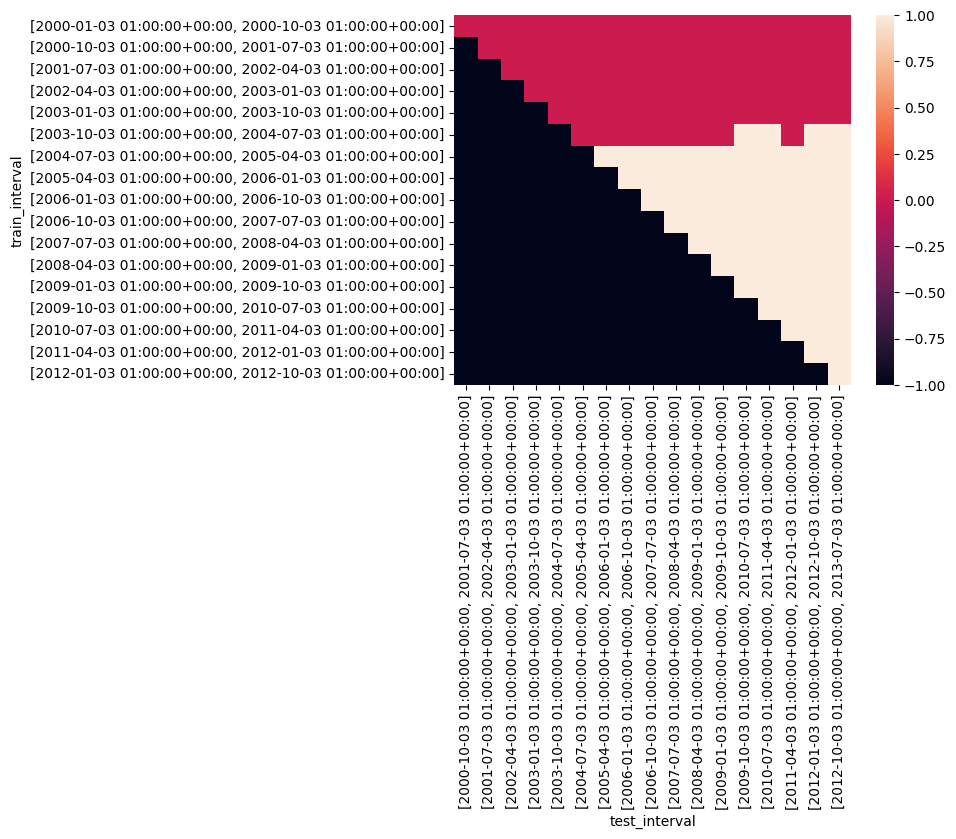

In [18]:
sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))

The conclusion is that there is no difference in the dataset since 2004. If we look into the details, we see that this resource stop appearing in the process in 2004. Actually, this coincides with the gap that we detected in the process in that year.

# RQ2: Does time have an influence on the quality of the models?
To answer this question, we are going to analyse the evolution of model performance using the first two strategies (new models each time and updating a model that includes all information):

In [19]:
from experiments import run_experiment_classifier, run_experiment_classifier_voting, compare_diag, compute_weights, shape_summary
from splitters import TimeCaseSplit, NumberCaseSplit

def launch_experiment_rq2(months_size, months_freq, months_test):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsV = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsF = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier(X, y, tcs.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier(X, y, tcsF.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V = run_experiment_classifier_voting(X, y, tcsV.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V

def launch_experiment_rolling(size, freq, window, steps, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),window, steps, summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), window, steps,summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V


def launch_experiment_number(size, freq, test, datasets=range(0,5)):
    tcsB = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20,threshold=500,  sliding=False)
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20,threshold=500,  sliding=True)
    tcsV = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False)
    tcsS = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False, sampling=True)
    print("Starting X_B (Baseline)")
    summary_X_B = run_experiment_classifier(X, y, tcsB.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_S')
    summary_X_S = run_experiment_classifier(X, y, tcsS.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X')
    summary_X = run_experiment_classifier(X, y, tcs.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F =run_experiment_classifier(X, y, tcsF.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V= run_experiment_classifier_voting(X, y, tcsV.split_old(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    
    return summary_X_B, summary_X, summary_X_F, summary_X_V, summary_X_S
        

In [20]:
summary_999 = launch_experiment_rq2(9,9,9)

Starting X
Starting X_F
Starting X_V


/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_23607/1147182583.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)


<Axes: >

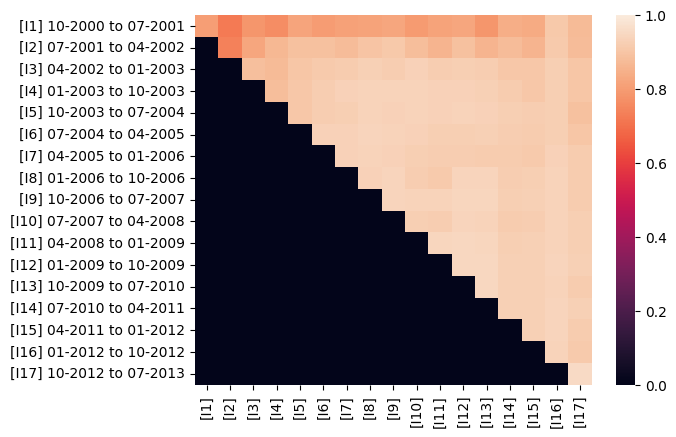

In [21]:
from experiments import shape_summary
draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_23607/2193391910.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score', axis=1, drop_level=True),vmax=1)


<Axes: >

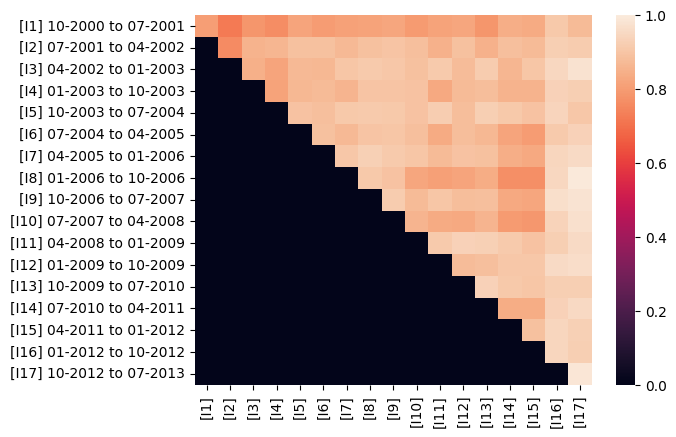

In [22]:
draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score', axis=1, drop_level=True),vmax=1)

In [23]:
#sns.heatmap(shape_summary(summary_9_F_r).fillna(0))

In [24]:
summary_n_B, summary_n, summary_n_F, summary_n_V, summary_n_S = launch_experiment_number(8641,4320,4320)

Starting X_B (Baseline)
Starting X_S
Sampling from: 8641 in 1
Sampling from: 12961 in 2
Sampling from: 17281 in 3
Sampling from: 21601 in 4
Sampling from: 25921 in 5
Sampling from: 30241 in 6
Sampling from: 34561 in 7
Sampling from: 38881 in 8
Sampling from: 43201 in 9
Sampling from: 47521 in 10
Sampling from: 51841 in 11
Sampling from: 56161 in 12
Sampling from: 60481 in 13
Sampling from: 64801 in 14
Sampling from: 69121 in 15
Sampling from: 73441 in 16
Sampling from: 77761 in 17
Sampling from: 82081 in 18
Sampling from: 86401 in 19
Sampling from: 90721 in 20
Sampling from: 95041 in 21
Sampling from: 99361 in 22
Sampling from: 103681 in 23
Sampling from: 108001 in 24
Sampling from: 112321 in 25
Sampling from: 116641 in 26
Sampling from: 120961 in 27
Sampling from: 125281 in 28
Sampling from: 129601 in 29
Sampling from: 129614 in 30
Starting X
Starting X_F
Starting X_V


/var/folders/gn/y9_k855j2h393t38kf2gfvwc0000gn/T/ipykernel_23607/3453255053.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(shape_summary(summary_n_F).fillna(0))


<Axes: xlabel='None-test', ylabel='train'>

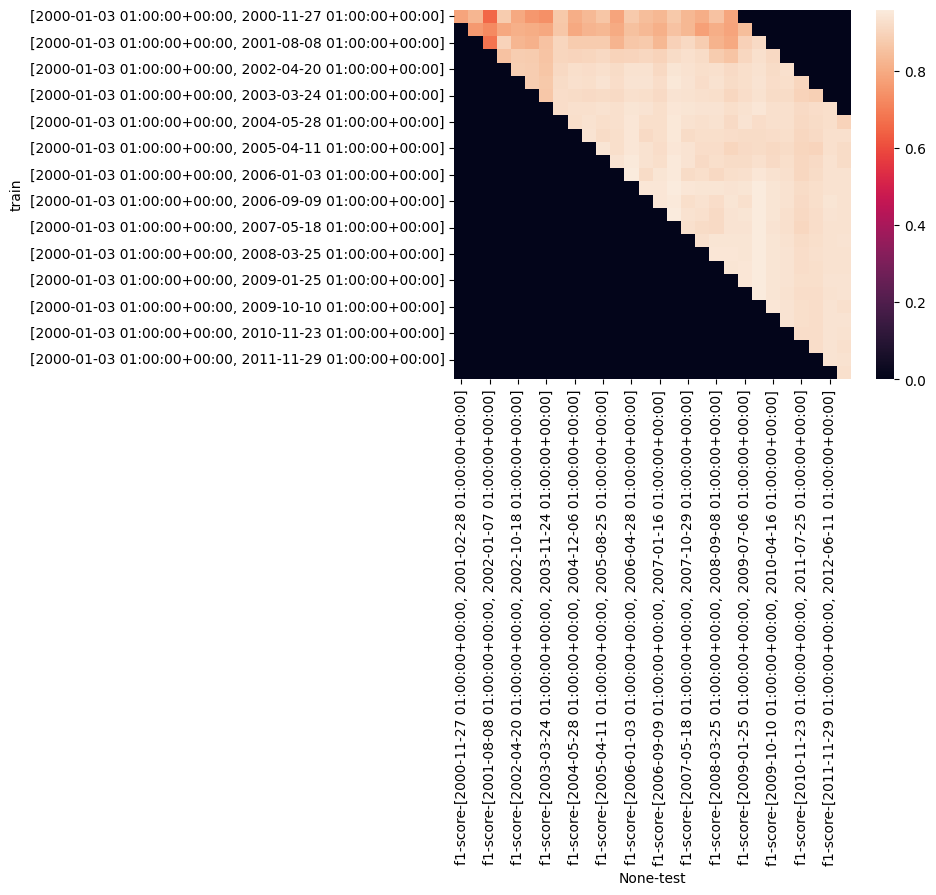

In [25]:
sns.heatmap(shape_summary(summary_n_F).fillna(0))

# RQ3: How does the different update strategies compare against each other?

Finally, we compute execute the experiment for all types of strategies. The final value is the mean of the F-Scores in the diagonal of the matrix obtained.

In [26]:
summary_n_all = [summary_n_B, summary_n, summary_n_F, summary_n_V, summary_n_S]

In [27]:
def extract_values(summary, step = 0):
    mask = summary[0].sort_values(['train','test']).groupby('train').cumcount() <= step
    return pd.concat([summary[i][mask]['f1-score'] for i in range(len(summary))],axis=1)

In [28]:
summary_n_fscore = extract_values(summary_n_all)
summary_n_fscore.columns = ['B', 'X','F','V','S']


In [29]:
summary_n_fscore.mean()

B     0.90751
X    0.882036
F     0.90751
V    0.899493
S    0.900581
dtype: object

Here, we use the T-test related to check whether there is a significant difference between each column. The result is that only the difference between 'V' and 'X is statistically significant.

In [30]:
from scipy import stats
[(i,j,stats.ttest_rel(summary_n_fscore[i], summary_n_fscore[j])) for ii,i in enumerate(summary_n_fscore.columns) for jj,j in enumerate(summary_n_fscore.columns) if i < j]

[('B',
  'X',
  TtestResult(statistic=3.617900963537465, pvalue=0.0012047682387507901, df=27)),
 ('B', 'F', TtestResult(statistic=nan, pvalue=nan, df=27)),
 ('B',
  'V',
  TtestResult(statistic=1.9245300328171435, pvalue=0.06488612101114215, df=27)),
 ('B',
  'S',
  TtestResult(statistic=4.293210994002412, pvalue=0.00020295151250505601, df=27)),
 ('F',
  'X',
  TtestResult(statistic=3.617900963537465, pvalue=0.0012047682387507901, df=27)),
 ('F',
  'V',
  TtestResult(statistic=1.9245300328171435, pvalue=0.06488612101114215, df=27)),
 ('F',
  'S',
  TtestResult(statistic=4.293210994002412, pvalue=0.00020295151250505601, df=27)),
 ('V',
  'X',
  TtestResult(statistic=3.3026982083411878, pvalue=0.002702194487075085, df=27)),
 ('S',
  'X',
  TtestResult(statistic=2.587104065500094, pvalue=0.01538636710200829, df=27)),
 ('S',
  'V',
  TtestResult(statistic=0.23717129012709504, pvalue=0.8143142727278982, df=27))]